In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from tqdm import tqdm

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import hdbscan
import umap.umap_ as umap
import matplotlib.pyplot as plt

DATA_DIR = Path("data")
CHUNKS_PATH = DATA_DIR / "chunks.parquet"
CHUNK_EMB_PATH = DATA_DIR / "chunk_embeddings.npy"

print("Data dir:", DATA_DIR)


c:\Users\Daniel Mondragon\Schoolwork\Intro to AI\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Data dir: data


In [2]:
df_chunks = pd.read_parquet(CHUNKS_PATH)
chunk_embs = np.load(CHUNK_EMB_PATH)

print(df_chunks.shape)
df_chunks.head()


(150, 5)


,chunk_id,entry_id,chunk_index,chunk_text,timestamp
0,1_c0,1,0,"I got frustrated over something small today, b...",2024-01-01
1,2_c0,2,0,My mind kept looping over tiny details that sh...,2024-01-02
2,3_c0,3,0,I enjoyed a quiet moment today that made me fe...,2024-01-03
3,4_c0,4,0,"I tried grounding techniques, but the tension ...",2024-01-04
4,5_c0,5,0,I spent some time analyzing my reactions today...,2024-01-05


In [3]:
pca_dims = 50

pca = PCA(n_components=pca_dims, random_state=42)
chunk_emb_pca = pca.fit_transform(chunk_embs)

print("PCA shape:", chunk_emb_pca.shape)
print("Explained variance ratio sum:", pca.explained_variance_ratio_.sum())


PCA shape: (150, 50)
Explained variance ratio sum: 0.9807779


In [4]:
hdb = hdbscan.HDBSCAN(
    min_cluster_size=8,
    min_samples=2,
    metric="euclidean",
    cluster_selection_method="eom",
    prediction_data=True
)

labels_hdb = hdb.fit_predict(chunk_emb_pca)
print("Unique clusters (HDBSCAN):", np.unique(labels_hdb))

df_chunks["cluster_hdbscan"] = labels_hdb


Unique clusters (HDBSCAN): [-1  0  1  2  3  4  5]


c:\Users\Daniel Mondragon\Schoolwork\Intro to AI\venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel Mondragon\Schoolwork\Intro to AI\venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [5]:
kmeans_k = 10

kmeans = KMeans(n_clusters=kmeans_k, random_state=42, n_init="auto")
labels_km = kmeans.fit_predict(chunk_emb_pca)

df_chunks["cluster_kmeans"] = labels_km

print("KMeans clusters:", np.unique(labels_km))


KMeans clusters: [0 1 2 3 4 5 6 7 8 9]


In [6]:
um = umap.UMAP(
    n_components=2,
    n_neighbors=15,
    min_dist=0.1,
    metric="euclidean",
    random_state=42
)

chunk_emb_2d = um.fit_transform(chunk_emb_pca)
df_chunks["umap_x"] = chunk_emb_2d[:, 0]
df_chunks["umap_y"] = chunk_emb_2d[:, 1]

df_chunks.head()


c:\Users\Daniel Mondragon\Schoolwork\Intro to AI\venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


,chunk_id,entry_id,chunk_index,chunk_text,timestamp,cluster_hdbscan,cluster_kmeans,umap_x,umap_y
0,1_c0,1,0,"I got frustrated over something small today, b...",2024-01-01,-1,5,3.530389,7.156374
1,2_c0,2,0,My mind kept looping over tiny details that sh...,2024-01-02,-1,2,3.600232,7.700221
2,3_c0,3,0,I enjoyed a quiet moment today that made me fe...,2024-01-03,5,0,1.358921,1.438396
3,4_c0,4,0,"I tried grounding techniques, but the tension ...",2024-01-04,-1,7,0.770253,5.550629
4,5_c0,5,0,I spent some time analyzing my reactions today...,2024-01-05,2,0,4.185555,8.442603


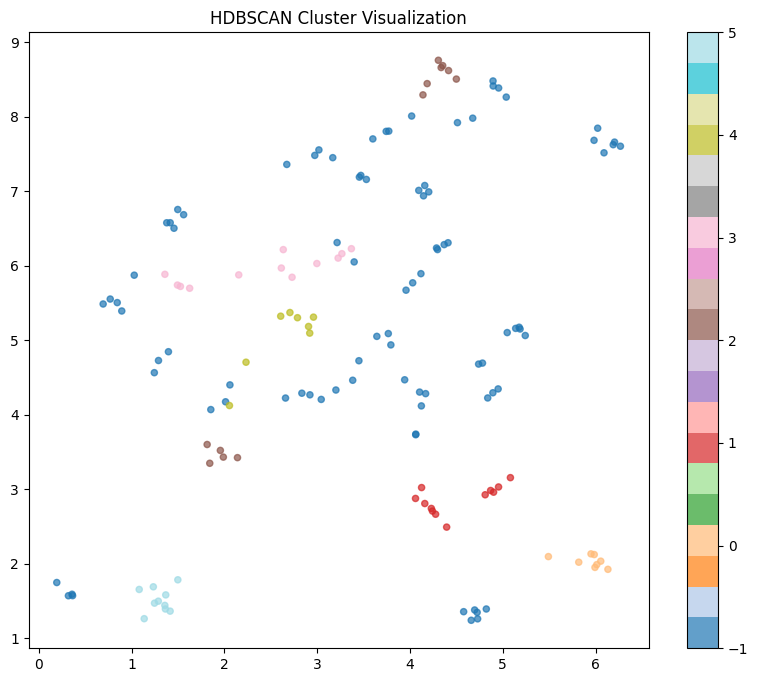

In [7]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    df_chunks["umap_x"],
    df_chunks["umap_y"],
    c=df_chunks["cluster_hdbscan"],
    cmap="tab20",
    s=20,
    alpha=0.7
)
plt.title("HDBSCAN Cluster Visualization")
plt.colorbar(scatter)
plt.show()


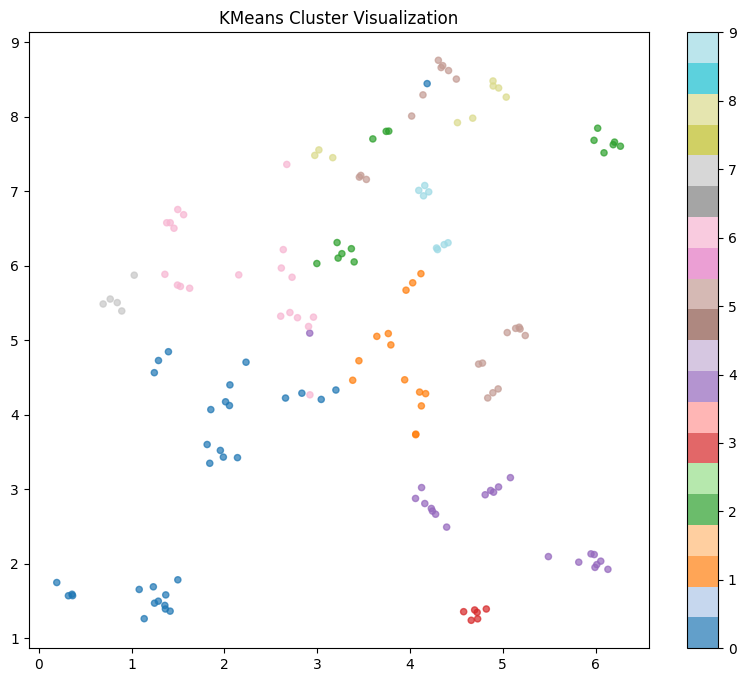

In [8]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    df_chunks["umap_x"],
    df_chunks["umap_y"],
    c=df_chunks["cluster_kmeans"],
    cmap="tab20",
    s=20,
    alpha=0.7
)
plt.title("KMeans Cluster Visualization")
plt.colorbar(scatter)
plt.show()


In [9]:
print("HDBSCAN cluster sizes:")
print(df_chunks["cluster_hdbscan"].value_counts())

print("\nKMeans cluster sizes:")
print(df_chunks["cluster_kmeans"].value_counts())


HDBSCAN cluster sizes:
cluster_hdbscan
-1    88
 2    12
 3    12
 1    12
 5    10
 0     8
 4     8
Name: count, dtype: int64

KMeans cluster sizes:
cluster_kmeans
0    32
4    21
6    20
5    20
2    15
1    14
8     9
9     8
3     6
7     5
Name: count, dtype: int64


In [10]:
cluster_samples_hdb = {}

for cluster_id in sorted(df_chunks["cluster_hdbscan"].unique()):
    if cluster_id == -1:
        # skip noise or keep it if you're curious
        continue

    examples = df_chunks[df_chunks["cluster_hdbscan"] == cluster_id]["chunk_text"].tolist()
    
    # take 8 samples (or fewer if cluster is small)
    cluster_samples_hdb[cluster_id] = examples[:8]

cluster_samples_hdb


{np.int64(0): ['A familiar smell brought back memories I hadn’t thought about in years. It made me pause for a while. I felt anxious today, like something bad was about to happen.',
  'A familiar smell brought back memories I hadn’t thought about in years. It made me pause for a while. I had a surprisingly peaceful day.',
  'A familiar smell brought back memories I hadn’t thought about in years. It made me pause for a while.',
  'A familiar smell brought back memories I hadn’t thought about in years. It made me pause for a while. I enjoyed a quiet moment today that made me feel genuinely content.',
  'Trying to keep up with everything drained me more than I expected. A familiar smell brought back memories I hadn’t thought about in years.',
  'A familiar smell brought back memories I hadn’t thought about in years. It made me pause for a while.',
  'A familiar smell brought back memories I hadn’t thought about in years. It made me pause for a while.',
  'A familiar smell brought back mem

In [11]:
cluster_samples_km = {}

for cluster_id in sorted(df_chunks["cluster_kmeans"].unique()):
    examples = df_chunks[df_chunks["cluster_kmeans"] == cluster_id]["chunk_text"].tolist()
    cluster_samples_km[cluster_id] = examples[:8]

cluster_samples_km


{np.int32(0): ['I enjoyed a quiet moment today that made me feel genuinely content. I wish those moments lasted longer.',
  'I spent some time analyzing my reactions today. I realized I still repeat patterns I thought I had abandoned. I had a surprisingly peaceful day.',
  'Today made me aware of some habits I want to break. I’m tired of repeating the same cycles. I got frustrated over something small today, but it spiraled into anger.',
  'I had a surprisingly peaceful day. Nothing extraordinary happened, but it felt calm.',
  'Today gave me a little spark of hope. I don’t know why, but it felt nice to breathe without heaviness for once.',
  'A simple routine task made me feel grounded. It was a good feeling. I felt really down today, like I was underwater emotionally.',
  'I enjoyed a quiet moment today that made me feel genuinely content. I wish those moments lasted longer.',
  'I enjoyed a quiet moment today that made me feel genuinely content. I wish those moments lasted longer.']

In [12]:
def build_prompt(cluster_id, samples):
    text = f"Cluster {cluster_id} sample chunks:\n\n"
    for i, chunk in enumerate(samples):
        text += f"--- Example {i+1} ---\n{chunk}\n\n"
    text += (
        "What is the psychological or emotional theme that unifies these excerpts?\n"
        "Describe it in 3–10 words."
    )
    return text

# Example for HDBSCAN
for cid, samples in list(cluster_samples_hdb.items())[:2]:
    print(build_prompt(cid, samples))
    print("="*80)
    break


Cluster 0 sample chunks:

--- Example 1 ---
A familiar smell brought back memories I hadn’t thought about in years. It made me pause for a while. I felt anxious today, like something bad was about to happen.

--- Example 2 ---
A familiar smell brought back memories I hadn’t thought about in years. It made me pause for a while. I had a surprisingly peaceful day.

--- Example 3 ---
A familiar smell brought back memories I hadn’t thought about in years. It made me pause for a while.

--- Example 4 ---
A familiar smell brought back memories I hadn’t thought about in years. It made me pause for a while. I enjoyed a quiet moment today that made me feel genuinely content.

--- Example 5 ---
Trying to keep up with everything drained me more than I expected. A familiar smell brought back memories I hadn’t thought about in years.

--- Example 6 ---
A familiar smell brought back memories I hadn’t thought about in years. It made me pause for a while.

--- Example 7 ---
A familiar smell brought bac

In [13]:
df_chunks.to_parquet(DATA_DIR / "chunks_with_clusters.parquet", index=False)

np.save(DATA_DIR / "chunk_embeddings_pca.npy", chunk_emb_pca)
